In [1]:
# 1. Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)


In [2]:
# 2. Load dataset
data_path = "diabetes.csv"  # sesuaikan jika path beda
df = pd.read_csv(data_path)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# 3. Info cepat & pengecekan singkat
display(df.describe())
display(df.isna().sum())

# Target dan fitur
target_col = "Outcome"
feature_cols = [c for c in df.columns if c != target_col]

# LabelEncoder untuk target (jika sudah numerik, ini eksplisit saja)
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])
class_names = le_target.classes_  # contoh: [0 1]


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

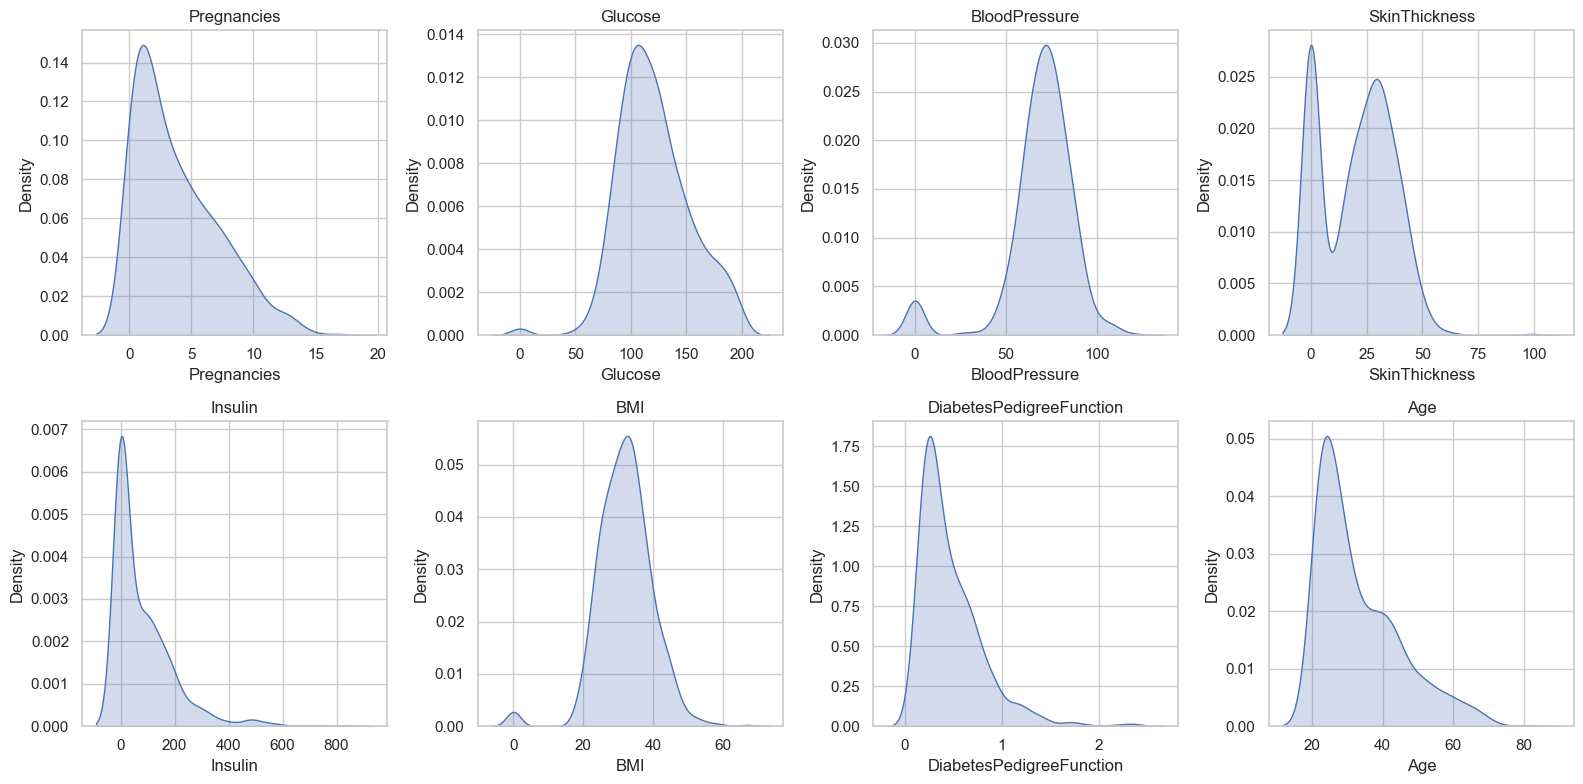

In [4]:
# 4. Visualisasi distribusi (KDE) untuk cek asumsi mendekati normal
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
for ax, col in zip(axes, feature_cols):
    sns.kdeplot(df[col], fill=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


In [5]:
# 5. Split data (80/20) dan scaling (wajib untuk GaussianNB)
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Accuracy: 0.708


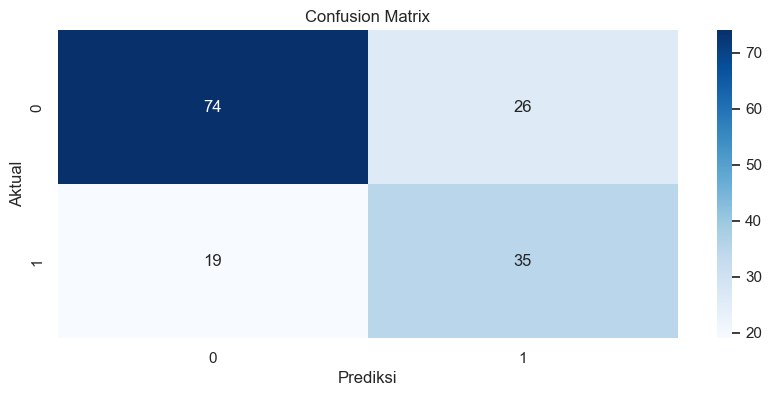

In [6]:
# 6. Modeling dengan GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

y_pred = gnb.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()


In [7]:
# 7. Analisis probabilitas pada satu sampel uji
y_test_array = y_test.to_numpy()
mis_idx = np.where(y_pred != y_test_array)[0]
if len(mis_idx) > 0:
    sample_idx = mis_idx[0]
    note = "Sampel salah diprediksi"
else:
    sample_idx = 0
    note = "Tidak ada salah prediksi, ambil sampel pertama"

sample_proba = gnb.predict_proba(X_test_scaled[sample_idx].reshape(1, -1))[0]

sample_df = pd.DataFrame({
    "Fitur": feature_cols,
    "Nilai_asli": X_test.iloc[sample_idx].values,
    "Nilai_terstandar": X_test_scaled[sample_idx]
})

display(sample_df)
print(note)
proba_df = pd.DataFrame(sample_proba.reshape(1, -1), columns=class_names)
display(proba_df)
print(f"Prediksi kelas: {class_names[gnb.predict(X_test_scaled[sample_idx].reshape(1, -1))[0]]}")


,Fitur,Nilai_asli,Nilai_terstandar
0,Pregnancies,7.000,0.960541
1,Glucose,159.000,1.207888
2,BloodPressure,64.000,-0.296015
3,SkinThickness,0.000,-1.311380
4,Insulin,0.000,-0.730766
5,BMI,27.400,-0.582217
6,DiabetesPedigreeFunction,0.294,-0.555791
7,Age,40.000,0.561034


Sampel salah diprediksi


,0,1
0,0.484073,0.515927


Prediksi kelas: 1


In [8]:
# 8. Simulasi prediksi 2 data dummy kontras
dummy_df = pd.DataFrame([
    {
        "Pregnancies": 2,
        "Glucose": 180,           # tinggi
        "BloodPressure": 70,
        "SkinThickness": 25,
        "Insulin": 100,
        "BMI": 33,
        "DiabetesPedigreeFunction": 0.5,
        "Age": 28                # muda
    },
    {
        "Pregnancies": 6,
        "Glucose": 95,            # rendah/normal
        "BloodPressure": 80,
        "SkinThickness": 35,
        "Insulin": 150,
        "BMI": 27,
        "DiabetesPedigreeFunction": 0.9,
        "Age": 55                # lebih tua
    }
], index=["User_A_muda_glukosa_tinggi", "User_B_tua_glukosa_rendah"])

dummy_scaled = scaler.transform(dummy_df)
dummy_pred = gnb.predict(dummy_scaled)
dummy_proba = gnb.predict_proba(dummy_scaled)

hasil_dummy = dummy_df.copy()
hasil_dummy["Prediksi"] = [class_names[c] for c in dummy_pred]
for i, cls in enumerate(class_names):
    hasil_dummy[f"proba_{cls}"] = dummy_proba[:, i]

display(hasil_dummy)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Prediksi,proba_0,proba_1
User_A_muda_glukosa_tinggi,2,180,70,25,100,33,0.5,28,1,0.260965,0.739035
User_B_tua_glukosa_rendah,6,95,80,35,150,27,0.9,55,0,0.652320,0.347680
